<a href="https://colab.research.google.com/github/Kavya-sree/Hair-Type-Classifier/blob/main/Hair_type_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import fastai
from fastai.vision.all import *

In [3]:
hair_types = 'curly','straight','wavy','kinky'
path = Path('D:\Hair-Type-Classifier\data')

In [4]:
fns = get_image_files(path)
fns

(#1375) [Path('D:/Hair-Type-Classifier/data/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg'),Path('D:/Hair-Type-Classifier/data/curly/0160dfee18352aa9bf5c6e617de9e07b4.jpg'),Path('D:/Hair-Type-Classifier/data/curly/03312ac556a7d003f7570657f80392c34.jpg'),Path('D:/Hair-Type-Classifier/data/curly/04c42898ce88fa04cb4eb7fec6c6dcf94.jpg'),Path('D:/Hair-Type-Classifier/data/curly/0fd85bcde626a95e20489c83f292d8204.jpg'),Path('D:/Hair-Type-Classifier/data/curly/1-curly-hair-with-bangs-CYFg6l_Ls4-.jpg'),Path('D:/Hair-Type-Classifier/data/curly/106dfcf4abe76990b585b2fc2e3c9f884.jpg'),Path('D:/Hair-Type-Classifier/data/curly/13-long-curly-haircut-BclM5gMly7s.jpg'),Path('D:/Hair-Type-Classifier/data/curly/1431bae992a4a870c351bc4ffbcbd3ac.jpg'),Path('D:/Hair-Type-Classifier/data/curly/18a1eaa662423ae798f8067505b1fbf04.jpg')...]

## Data Loader
DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

In [5]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

With `DataBlock` API you can fully customize every stage of the creation of your `DataLoaders`.

In [6]:
hair_type = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [7]:
dls = hair_type.dataloaders(path)

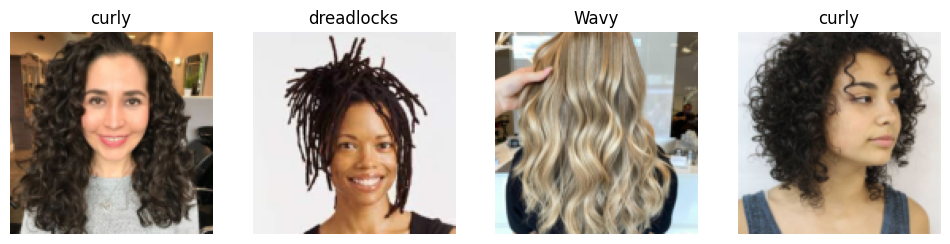

In [8]:
dls.valid.show_batch(max_n=4, nrows=1)

# Modelling

We don't have a lot of data for our problem, so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [9]:
hair = hair_type.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hair.dataloaders(path)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ACER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.82MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.873470,0.511642,0.167273,02:10


epoch,train_loss,valid_loss,error_rate,time
0,0.621493,0.417873,0.145455,02:43
1,0.488030,0.386805,0.112727,02:37
2,0.414964,0.395828,0.112727,02:50
3,0.361479,0.386651,0.120000,02:57
4,0.310054,0.371965,0.116364,02:46


d:\Hair-Type-Classifier\pyenvhair\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch

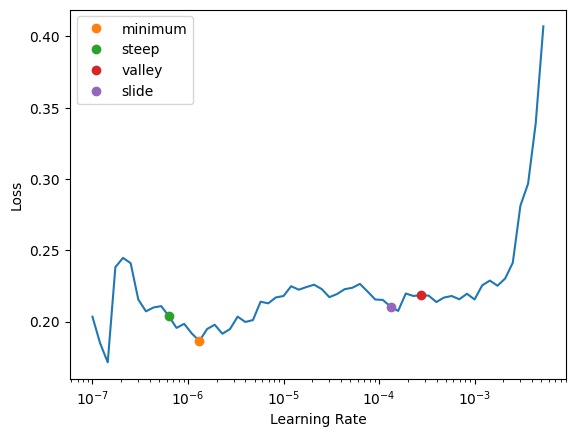

In [11]:
learn.save('stage-1')
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [12]:
learn.fit_one_cycle(10, lrs.valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.187383,0.375651,0.123636,01:16
1,0.193238,0.432069,0.116364,01:25
2,0.235589,0.670000,0.185455,01:12
3,0.261007,0.639215,0.138182,01:03
4,0.235786,0.449738,0.109091,01:04
5,0.211118,0.434629,0.098182,01:05
6,0.183116,0.395287,0.090909,01:05
7,0.158839,0.388765,0.087273,01:05
8,0.134935,0.364623,0.087273,01:06
9,0.121117,0.363515,0.090909,01:07


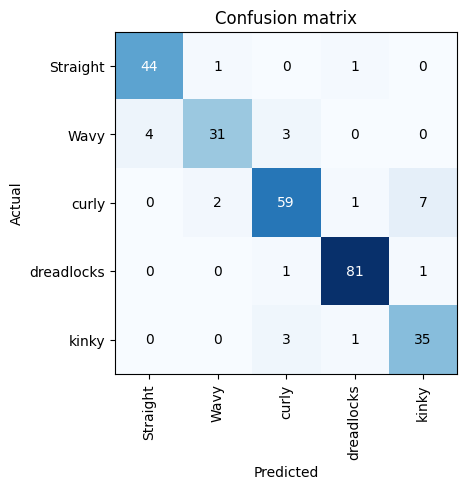

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

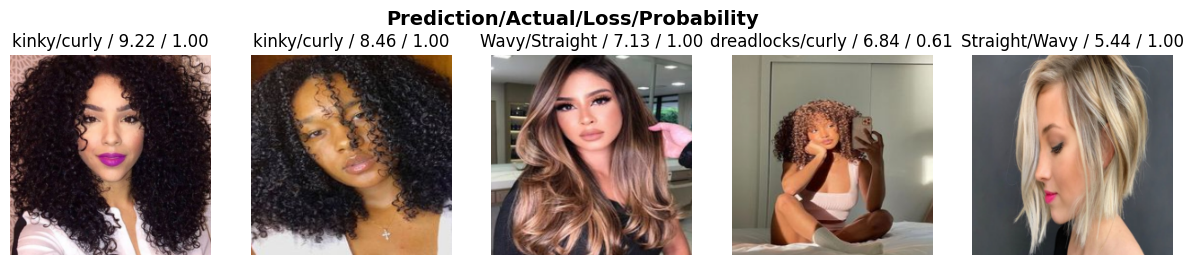

In [15]:
interp.plot_top_losses(5, nrows=1)

In [18]:
learn.export("models/hair-resnet18-model.pkl")